<a href="https://colab.research.google.com/github/viniciusgribas/Energ-IA/blob/main/Test_00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://medium.com/@lorevanoudenhove/how-to-build-ai-agents-with-langgraph-a-step-by-step-guide-5d84d9c7e832


In [19]:
import boto3
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.graph import StateGraph , START, END


from langchain_aws import ChatBedrock

from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import ToolMessage

from langchain_community.tools.tavily_search import TavilySearchResults




In [3]:
# @tool
# -> This one should be a Class.
def compute_savings(monthly_cost: float) -> float:
    """
    Tool to compute the potential savings when switching to solar energy based on the user's monthly electricity cost.
    
    Args:
        monthly_cost (float): The user's current monthly electricity cost.
    
    Returns:
        dict: A dictionary containing:
            - 'number_of_panels': The estimated number of solar panels required.
            - 'installation_cost': The estimated installation cost.
            - 'net_savings_10_years': The net savings over 10 years after installation costs.
    """

    # Return calculated solar savings
    return __calculate_solar_savings(monthly_cost)


def __calculate_solar_savings(monthly_cost):
    # Assumptions for the calculation
    cost_per_kWh = 0.28  
    cost_per_watt = 1.50  
    sunlight_hours_per_day = 3.5  
    panel_wattage = 350  
    system_lifetime_years = 10  

    # Monthly electricity consumption in kWh
    monthly_consumption_kWh = monthly_cost / cost_per_kWh
    
    # Required system size in kW
    daily_energy_production = monthly_consumption_kWh / 30
    system_size_kW = daily_energy_production / sunlight_hours_per_day
    
    # Number of panels and installation cost
    number_of_panels = system_size_kW * 1000 / panel_wattage
    installation_cost = system_size_kW * 1000 * cost_per_watt
    
    # Annual and net savings
    annual_savings = monthly_cost * 12
    total_savings_10_years = annual_savings * system_lifetime_years
    net_savings = total_savings_10_years - installation_cost
    
    return {
        "number_of_panels": round(number_of_panels),
        "installation_cost": round(installation_cost, 2),
        "net_savings_10_years": round(net_savings, 2)
    }

In [4]:
def handle_tool_error(state) -> dict:
    """
    Function to handle errors that occur during tool execution.
    
    Args:
        state (dict): The current state of the AI agent, which includes messages and tool call details.
    
    Returns:
        dict: A dictionary containing error messages for each tool that encountered an issue.
    """
    # Retrieve the error from the current state
    error = state.get("error")
    
    # Access the tool calls from the last message in the state's message history
    tool_calls = state["messages"][-1].tool_calls
    
    # Return a list of ToolMessages with error details, linked to each tool call ID
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",  # Format the error message for the user
                tool_call_id=tc["id"],  # Associate the error message with the corresponding tool call ID
            )
            for tc in tool_calls  # Iterate over each tool call to produce individual error messages
        ]
    }

def create_tool_node_with_fallback(tools: list) -> dict:
    """
    Function to create a tool node with fallback error handling.
    
    Args:
        tools (list): A list of tools to be included in the node.
    
    Returns:
        dict: A tool node that uses fallback behavior in case of errors.
    """
    # Create a ToolNode with the provided tools and attach a fallback mechanism
    # If an error occurs, it will invoke the handle_tool_error function to manage the error
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)],  # Use a lambda function to wrap the error handler
        exception_key="error"  # Specify that this fallback is for handling errors
    )

In [5]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

class Assistant:
    def __init__(self, runnable: Runnable):
        # Initialize with the runnable that defines the process for interacting with the tools
        self.runnable = runnable

    def __call__(self, state: State):
        while True:
            # Invoke the runnable with the current state (messages and context)
            result = self.runnable.invoke(state)
            
            # If the tool fails to return valid output, re-prompt the user to clarify or retry
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                # Add a message to request a valid response
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                # Break the loop when valid output is obtained
                break

        # Return the final state after processing the runnable
        return {"messages": result}

In [6]:
def get_bedrock_client(region):
    return boto3.client("bedrock-runtime", region_name=region)

def create_bedrock_llm(client):
    return ChatBedrock(model_id='anthropic.claude-3-sonnet-20240229-v1:0', client=client, model_kwargs={'temperature': 0}, region_name='us-east-1')


In [7]:
llm = create_bedrock_llm(get_bedrock_client(region='us-east-1'))

In [8]:
llm

ChatBedrock(client=<botocore.client.BedrockRuntime object at 0x74fba46b7710>, region_name='us-east-1', model_id='anthropic.claude-3-sonnet-20240229-v1:0', model_kwargs={}, temperature=0)

In [9]:
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            '''You are a helpful customer support assistant for Solar Panels Belgium.
            You should get the following information from them:
            - monthly electricity cost
            If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

            After you are able to discern all the information, call the relevant tool.
            ''',
        ),
        ("placeholder", "{messages}"),
    ]
)

In [10]:
# Define the tools the assistant will use
part_1_tools = [
    compute_savings
]

# Bind the tools to the assistant's workflow
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

In [11]:
part_1_assistant_runnable

ChatPromptTemplate(input_variables=[], optional_variables=['messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annot

In [14]:
builder = StateGraph(State)
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))

In [17]:
builder.add_edge(START, "assistant")  # Start with the assistant
builder.add_conditional_edges("assistant", tools_condition)  # Move to tools after input
builder.add_edge("tools", "assistant")  # Return to assistant after tool execution

In [20]:
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [23]:
memory

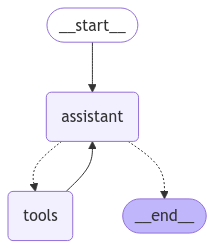

In [22]:
graph

In [24]:
# import shutil
import uuid

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    'hey',
    'can you calculate my energy saving',
    "my montly cost is $100, what will i save"
]

thread_id = str(uuid.uuid4())

In [28]:
thread_id

'de8bbf68-8bbe-4f3d-a2e6-0c344435e74b'

In [30]:
config = {
    "configurable": {
        "thread_id": thread_id,
    }
}


In [32]:
_printed = set()

In [33]:


for question in tutorial_questions:
    events = graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

NameError: name '_print_event' is not defined

NameError: name '_print_event' is not defined

In [ ]:
compute_savings(float(100))